<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/1404_07_23_one_sensor_state0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/ASCE"

shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [5]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        channels = []
        for f in raw._fieldnames:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)  # (n_samples, n_channels)
    else:
        raise ValueError("Unexpected MAT structure. 'dasy' not a struct.")
    return data  # float64 by default

base_dir = '/content/drive/MyDrive/ASCE/'
state_files = {
    1: 'shm01a.mat', 2: 'shm02a.mat', 3: 'shm03a.mat',
    4: 'shm04a.mat', 5: 'shm05a.mat', 6: 'shm06a.mat',
    7: 'shm07a.mat', 8: 'shm08a.mat', 9: 'shm09a.mat',
}
# label_to_class_id: 1..9 -> 0..8
label_to_cid = {lab: i for i, lab in enumerate(sorted(state_files.keys()))}

scenario_data = {}   # cid -> np.ndarray [N, C]
for lab, fname in state_files.items():
    x = load_mat(os.path.join(base_dir, fname)).astype(np.float32)
    scenario_data[label_to_cid[lab]] = x
print(scenario_data[0][:,:].shape)
print(scenario_data[0][:,4].shape)
print(scenario_data[4][:,4].shape)
    # print(fname, x.shape)

(60000, 16)
(60000,)
(60000,)


(60000,)
[-0.0027374  -0.0022796  -0.00162676 ... -0.0025698  -0.00189136
 -0.0011516 ]
Max =  0.00035812
Min =  -0.0037434
(60000,)
Max =  -0.0018175
Min =  -0.0027156


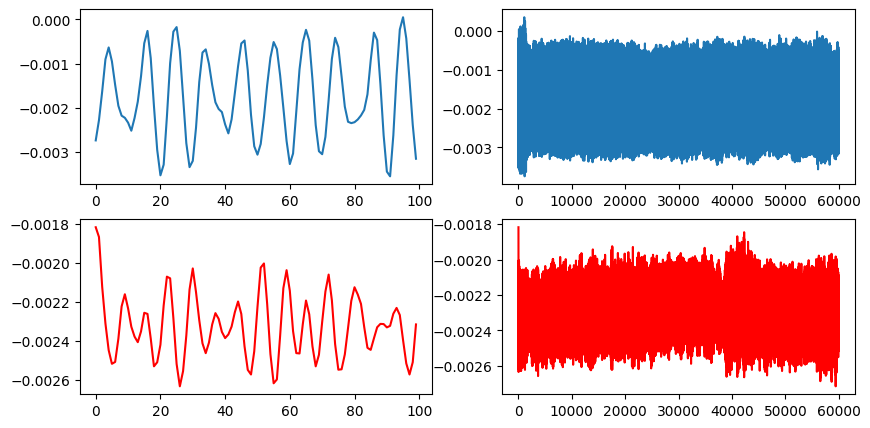

In [6]:
print(scenario_data[0][:,4].shape)
print(scenario_data[0][:,4])
print('Max = ',max(scenario_data[0][:,4]))
print('Min = ',min(scenario_data[0][:,4]))
fig , axs = plt.subplots(2,2,figsize=(10,5))
axs[0,0].plot(scenario_data[0][:100,4])
axs[0,1].plot(scenario_data[0][:,4])

print(scenario_data[1][:,4].shape)
print('Max = ',max(scenario_data[1][:,4]))
print('Min = ',min(scenario_data[1][:,4]))
axs[1,0].plot(scenario_data[1][:100,4],c='r')
axs[1,1].plot(scenario_data[1][:,4],c='r')


In [7]:
def make_windows(data, window_length, drop_last : bool = True):
    # Calculate how many full frames can be created
    num_frames = len(data) // window_length
    # print(num_frames)
    # Trim the data to be a perfect multiple of the frame length
    trimmed_data = data[:num_frames * window_length]

    # Reshape the data into a 2D array of frames
    windows = trimmed_data.reshape((num_frames, window_length))
    # return trimmed_data.shape , frames.shape
    return windows

In [8]:
win = 128
healthy_frames = make_windows(scenario_data[0][:,4], window_length = win, drop_last=True)
print("Frames:", healthy_frames.shape)
damaged_frames = make_windows(scenario_data[1][:,4], window_length = win, drop_last=True)
print("Frames:", damaged_frames.shape)

Frames: (468, 128)
Frames: (468, 128)


In [9]:
healthy_labels = np.zeros(len(healthy_frames), dtype=int)
print(healthy_labels.shape)

damaged_labels = np.ones(len(damaged_frames), dtype=int)
print(damaged_labels.shape)

(468,)
(468,)


In [10]:
n_train = 0.7
n_val = 0.15

m_0 = int(n_train * len(healthy_frames))
l_0 = int(n_val * len(healthy_frames))

m_1 = int(n_train * len(damaged_frames))
l_1 = int(n_val * len(damaged_frames))

X_train_0 = healthy_frames[0:m_0, :]
X_val_0 = healthy_frames[m_0 :m_0+l_0, :]
X_test_0 = healthy_frames[m_0+l_0:, :]

X_train_1 = healthy_frames[0:m_1, :]
X_val_1 = healthy_frames[m_1 :m_1+l_1, :]
X_test_1 = healthy_frames[m_1+l_1:, :]


In [11]:
print(X_train_0.shape)
print(X_val_0.shape)
print(X_test_0.shape)

(327, 128)
(70, 128)
(71, 128)


In [12]:
X_train = np.vstack([X_train_0, X_train_1])[:, :, None]  # [N, 5, 1]
print(X_train.shape)
print(healthy_labels[0:int(len(X_train_0))].shape)
print(damaged_labels[0:int(len(X_train_1))])

y_train = np.concatenate([healthy_labels[0:int(len(X_train_0))], damaged_labels[0:int(len(X_train_1))]])             # [N]
print(y_train.shape)

(654, 128, 1)
(327,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(654,)


In [14]:
X_val =  np.vstack([X_val_0, X_val_1])[:, :, None]  # [N, 5, 1]
print(X_val.shape)
# print(X)
y_val = np.concatenate([healthy_labels[int(len(X_train_0)): int(len(X_train_0) + len(X_val_0))], damaged_labels[int(len(X_train)): int(len(X_train) + len(X_val))]], axis=0)             # [N]
print(y_val.shape) # Corrected to print y_val shape

(140, 128, 1)
(70,)


In [15]:
X_test =  np.vstack([X_test_0, X_test_1])[:, :, None]  # [N, 5, 1]
print(X_test.shape)
# print(X)
y_test = np.concatenate([healthy_labels[int(len(X_train_0) + len(X_val_0)):], damaged_labels[int(len(X_train_1) + len(X_val_1)):]], axis=0)             # [N]
print(y_test.shape) # Corrected to print y_val shape

(142, 128, 1)
(142,)


In [16]:
# 5) Torch tensors
X_train = torch.from_numpy(X_train).float()  # float32
y_train = torch.from_numpy(y_train).long()  # int64
X_val   = torch.from_numpy(X_val).float()
y_val   = torch.from_numpy(y_val).long()
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

In [17]:
mu  = X_train.mean(axis=(0), keepdims=True)
std = X_train.std(axis=(0), keepdims=True) + 1e-6
X_train = (X_train - mu) / std
X_val   = (X_val   - mu) / std
X_test  = (X_test  - mu) / std

In [18]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([654, 128, 1]) torch.Size([654])
torch.Size([140, 128, 1]) torch.Size([70])
torch.Size([142, 128, 1]) torch.Size([142])


In [ ]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X  # [N, seq_len, 1]
        self.y = y  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
# print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

In [ ]:
# 6) DataLoaders: shuffle only the training set
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:
with torch.no_grad():
    ys_tr = torch.cat([yb.view(-1) for _, yb in train_loader], dim=0).cpu()
    ys_va = torch.cat([yb.view(-1) for _, yb in val_loader], dim=0).cpu()

print("train label set/counts:", ys_tr.unique(return_counts=True))
print("val   label set/counts:", ys_va.unique(return_counts=True))
print("train min/max:", ys_tr.min().item(), ys_tr.max().item())
print("val   min/max:", ys_va.min().item(), ys_va.max().item())

train label set/counts: (tensor([0, 1]), tensor([374, 374]))
val   label set/counts: (tensor([0, 1]), tensor([47, 47]))
train min/max: 0 1
val   min/max: 0 1


In [ ]:
# 7) Example: adapt a batch for a Transformer [seq_len, batch, d_model]
xb, yb = next(iter(train_loader))   # xb: [B, 5, 1]

In [ ]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=4, num_layers=3, d_ff=256, seq_len= X_train.shape[1], num_classes=2, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(1, d_model)                            # project feature_dim=1 -> d_model
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time

        logits = self.head(x)            # [B, C]
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = X_train.shape[1]
num_classes = 2
model = TimeSeriesTransformer(
    d_model=256,
    nhead=8,
    num_layers=4,
    d_ff=256,
    seq_len=seq_len ,
    num_classes=2,
    dropout=.3).to(device)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) # Move the model to the selected device

Using device: cuda


TimeSeriesTransformer(
  (inp): Linear(in_features=1, out_features=256, bias=True)
  (pos): LearnablePositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
# Optional class weights for CE or focal alpha; compute from training labels
class_counts = torch.bincount(y_train)
class_weights = (class_counts.sum() / (class_counts.float().clamp(min=1)))  # inverse freq
class_weights = class_weights / class_weights.sum() * num_classes           # normalize
class_weights = class_weights.to(device)

In [ ]:
# from torch.optim.lr_scheduler import CosineAnnealingLR
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
# # loss_fn = nn.CrossEntropyLoss()
# from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 50
tr_losses, tr_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
     model.train()
     total_loss, total_samples, correct_predictions = 0, 0, 0
     for xb, yb in train_loader:
        xb , yb = xb.to(device) , yb.to(device).long()
        optimizer.zero_grad()
        output = model(xb)
        # print('output',output)
        # print('max',torch.max(output, 1))
        # print('yb',yb)

        loss = loss_fn(output , yb)
        # print('loss',loss)
        # optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        # print(loss.item())
        # print(xb.size(0))
        # print('total:',total_loss)

        # Calculate accuracy
        pred = output.argmax(dim=1) # the index of the maximum value for each column
        # print('p',predicted)
        # print('real',yb)
        total_samples += xb.size(0)
        # print(total_samples)
        correct_predictions += (pred == yb).sum().item()
        # print(correct_predictions)

     epoch_loss = total_loss / total_samples
     epoch_accuracy = correct_predictions / total_samples
     tr_losses.append(epoch_loss)
     tr_accs.append(epoch_accuracy)

    #  print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f}")

     model.eval()
     val_correct_predictions , val_total_samples , val_total_loss = 0 , 0 , 0

     with torch.no_grad():
          for xb, yb in val_loader:
              xb, yb = xb.to(device), yb.to(device).long()
              output = model(xb)
              val_loss = loss_fn(output,yb)
              val_total_loss += val_loss.item() * xb.size(0)
              pred = output.argmax(dim=1)
              val_total_samples += xb.size(0)
              val_correct_predictions += (pred == yb).sum().item()

     val_epoch_loss = val_total_loss / val_total_samples
     val_epoch_accuracy = val_correct_predictions / val_total_samples
    #  print(    f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")
     val_losses.append(val_epoch_loss)
     val_accs.append(val_epoch_accuracy)
     # 3) Step the scheduler once per epoch, after validation
    #  scheduler.step()

     # Optional: print current lr to confirm schedule
     current_lr = optimizer.param_groups[0]["lr"]
     print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f} | "f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")




Epoch 1/50: Train Loss: 1.0134, Train Accuracy: 0.5241 | Validation Loss: 0.8391, Validation Accuracy: 0.5000

Epoch 2/50: Train Loss: 0.7955, Train Accuracy: 0.4813 | Validation Loss: 0.6951, Validation Accuracy: 0.5000

Epoch 3/50: Train Loss: 0.7120, Train Accuracy: 0.5160 | Validation Loss: 0.7041, Validation Accuracy: 0.5000

Epoch 4/50: Train Loss: 0.6990, Train Accuracy: 0.4906 | Validation Loss: 0.6931, Validation Accuracy: 0.5000

Epoch 5/50: Train Loss: 0.6958, Train Accuracy: 0.4893 | Validation Loss: 0.7007, Validation Accuracy: 0.5000

Epoch 6/50: Train Loss: 0.7006, Train Accuracy: 0.5027 | Validation Loss: 0.7104, Validation Accuracy: 0.5000

Epoch 7/50: Train Loss: 0.7057, Train Accuracy: 0.4960 | Validation Loss: 0.7020, Validation Accuracy: 0.5000

Epoch 8/50: Train Loss: 0.7130, Train Accuracy: 0.4733 | Validation Loss: 0.6956, Validation Accuracy: 0.5000

Epoch 9/50: Train Loss: 0.6964, Train Accuracy: 0.5281 | Validation Loss: 0.7105, Validation Accuracy: 0.5000

E

In [ ]:
model.train()
xb_small, yb_small = next(iter(train_loader))
xb_small, yb_small = xb_small.to(device), yb_small.to(device).long()
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
crit = torch.nn.CrossEntropyLoss()
for i in range(100):
    opt.zero_grad()
    logits = model(xb_small)             # [B, 2]
    loss = crit(logits, yb_small)        # yb_small shape [B], values {0,1}
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    if i % 20 == 0:
        pred = logits.argmax(1)
        acc = (pred == yb_small).float().mean().item()
        print(i, f'loss={loss.item():.4f}', f'acc={acc:.3f}')


0 loss=0.6964 acc=0.484
20 loss=0.6975 acc=0.484
40 loss=0.6933 acc=0.516
60 loss=0.6933 acc=0.516
80 loss=0.6942 acc=0.516


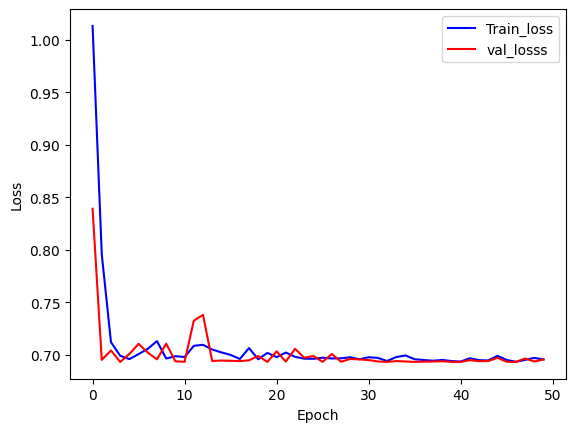

In [ ]:
epoch = np.arange(0,num_epochs , 1)
import matplotlib.pyplot as plt

plt.plot(epoch, tr_losses , label="Train_loss", c='b')
plt.plot(epoch, val_losses, label="val_losss", c='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

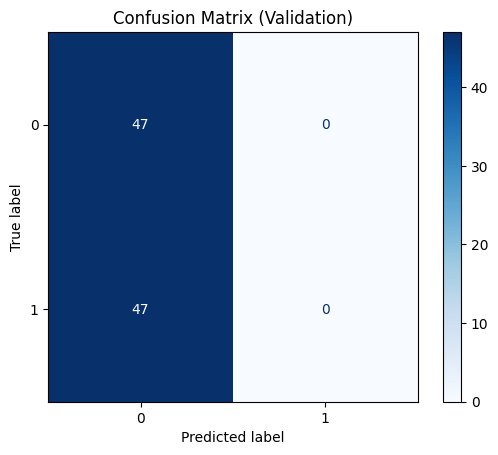

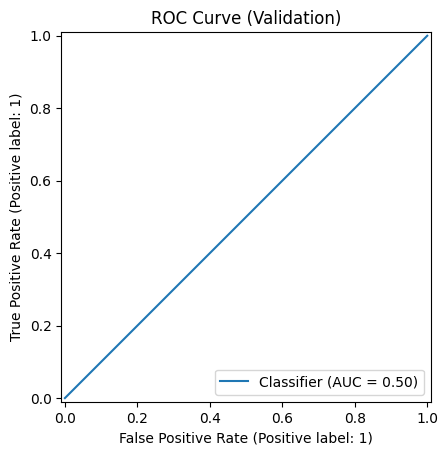

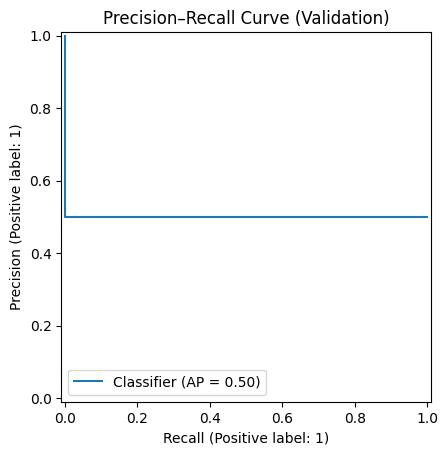

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B,2]

        # 1) Probability of class 1
        probs  = torch.softmax(logits, dim=1)          # [B,2]
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist())

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# 2) ROC
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve (Validation)")
plt.show()

# 3) Precision–Recall
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision–Recall Curve (Validation)")
plt.show()

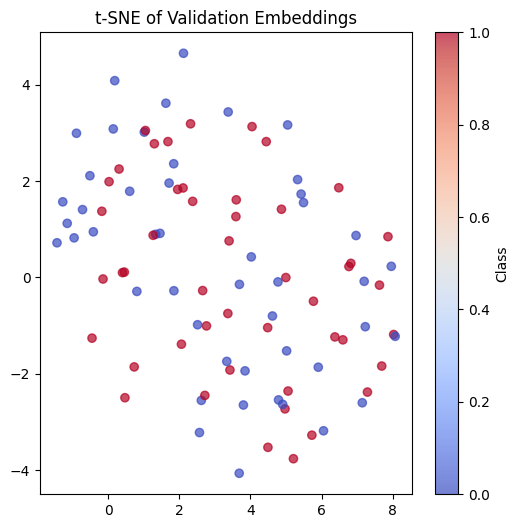

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()